<a href="https://colab.research.google.com/github/siddhartha-alexander/Primetrade.ai/blob/main/Primetrade_ai_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trader Behavior vs Market Sentiment — Assignment
**Candidate:** Damala Siddhartha Alexander  
**Deliverable:** `notebook_1.ipynb` (Colab) — produces `csv_files/`, `outputs/`, and content for `ds_report.pdf`.

**Overview:**  
Analyze how trader behavior (profitability, volume, leverage, winrate) aligns with market sentiment (Fear / Greed). This notebook:
- loads trader & sentiment datasets
- cleans and aggregates daily metrics
- merges sentiment
- performs EDA, statistical tests, and saves outputs


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
print("Folders created: csv_files/ and outputs/")


Folders created: csv_files/ and outputs/


## How to provide files
Place the two dataset files in the Colab workspace or your Drive and update the file paths below:
- Historical trader dataset CSV: `historical_trader_data.csv`
- Fear & Greed CSV: `fear_greed_index.csv`

If your files are on Google Drive, mount Drive and update paths accordingly.


In [51]:
trader_path = '/content/historical_data.csv'
sentiment_path = '/content/fear_greed_index.csv'
def safe_read_csv(path):
    if os.path.exists(path):
        return pd.read_csv(path, low_memory=False)
    else:
        raise FileNotFoundError(f"File not found: {path}. Upload it to Colab or set correct Drive path.")

trader = safe_read_csv(trader_path)
sent = safe_read_csv(sentiment_path)

print("Trader shape:", trader.shape)
print("Sentiment shape:", sent.shape)
trader.head()


Trader shape: (211224, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Quick inspection
Run the next cell to display `df.info()` and the first few rows of both tables so we can confirm column names and formats.


In [52]:
display(trader.info())
display(trader.head(5))
display(sent.info())
display(sent.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

None

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


None

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## Preprocessing plan
1. Convert trader `Timestamp IST` into datetime and create `date` (date-only) for daily aggregation.  
2. Ensure numeric columns (Size USD, Closed PnL, Execution Price, Fee) are numeric.  
3. Convert sentiment `date` to datetime date-only and standardize sentiment label column to `classification`.  
4. Handle missing values minimally (we will keep rows unless critical).


In [53]:
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], errors='coerce')
trader['date'] = trader['Timestamp IST'].dt.date
num_cols = ["Execution Price", "Size Tokens", "Size USD", "Start Position", "Closed PnL", "Fee"]
for c in num_cols:
    if c in trader.columns:
        trader[c] = pd.to_numeric(trader[c], errors='coerce')
print("After preprocessing trader:")
display(trader[['Timestamp IST','date']].head())
display(trader[num_cols].describe())


After preprocessing trader:


,Timestamp IST,date
0,2024-02-12 22:50:00,2024-02-12
1,2024-02-12 22:50:00,2024-02-12
2,2024-02-12 22:50:00,2024-02-12
3,2024-02-12 22:50:00,2024-02-12
4,2024-02-12 22:50:00,2024-02-12


,Execution Price,Size Tokens,Size USD,Start Position,Closed PnL,Fee
count,211224.000000,2.112240e+05,2.112240e+05,2.112240e+05,211224.000000,211224.000000
mean,11414.723350,4.623365e+03,5.639451e+03,-2.994625e+04,48.749001,1.163967
std,29447.654868,1.042729e+05,3.657514e+04,6.738074e+05,919.164828,6.758854
min,0.000005,8.740000e-07,0.000000e+00,-1.433463e+07,-117990.104100,-1.175712
25%,4.854700,2.940000e+00,1.937900e+02,-3.762311e+02,0.000000,0.016121
50%,18.280000,3.200000e+01,5.970450e+02,8.472793e+01,0.000000,0.089578
75%,101.580000,1.879025e+02,2.058960e+03,9.337278e+03,5.792797,0.393811
max,109004.000000,1.582244e+07,3.921431e+06,3.050948e+07,135329.090100,837.471593


In [54]:
sent.columns = [c.strip() for c in sent.columns]
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date
elif 'timestamp' in sent.columns:
    sent['date'] = pd.to_datetime(sent['timestamp'], errors='coerce').dt.date
else:
    raise ValueError("No date-like column found in sentiment dataset. Columns: " + ", ".join(sent.columns))
class_col = None
for c in sent.columns:
    if 'class' in c.lower():
        class_col = c
        break
if class_col is None:
    raise ValueError("No classification column found in sentiment dataset. Columns: " + ", ".join(sent.columns))

sent = sent.rename(columns={class_col: 'classification'})

print("Sentiment preprocessing done. Examples:")
display(sent[['date','classification']].head(10))


Sentiment preprocessing done. Examples:


,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear
5,2018-02-06,Extreme Fear
6,2018-02-07,Fear
7,2018-02-08,Fear
8,2018-02-09,Fear
9,2018-02-10,Neutral


In [55]:
trader['win'] = trader['Closed PnL'] > 0

daily = trader.groupby('date').agg(
    total_trades = ('Account','count'),
    volume = ('Size USD','sum'),
    avg_leverage = ( 'Start Position', 'mean' ),
    total_pnl = ('Closed PnL','sum'),
    avg_pnl = ('Closed PnL','mean'),
    winrate = ('win','mean')
).reset_index()
if 'leverage' in trader.columns:
    daily['avg_leverage'] = trader.groupby('date')['leverage'].mean().values
daily = daily.sort_values('date').reset_index(drop=True)
display(daily.head())


,date,total_trades,volume,avg_leverage,total_pnl,avg_pnl,winrate
0,2023-01-05,3,477.00,0.091933,0.000000,0.000000,0.000000
1,2023-05-12,9,50005.83,2.513867,0.000000,0.000000,0.000000
2,2024-01-01,18,264239.53,414.773256,-129.531460,-7.196192,0.055556
3,2024-01-02,6,2008.18,18562.666667,0.000000,0.000000,0.000000
4,2024-01-03,137,472974.70,375587.745255,8244.241409,60.176945,0.934307


In [56]:
daily = pd.merge(daily, sent[['date','classification']], on='date', how='left')
daily['classification'] = daily['classification'].fillna('Unknown')
print("Merged daily shape:", daily.shape)
display(daily.head(10))


Merged daily shape: (188, 8)


,date,total_trades,volume,avg_leverage,total_pnl,avg_pnl,winrate,classification
0,2023-01-05,3,477.00,0.091933,0.000000,0.000000,0.000000,Fear
1,2023-05-12,9,50005.83,2.513867,0.000000,0.000000,0.000000,Neutral
2,2024-01-01,18,264239.53,414.773256,-129.531460,-7.196192,0.055556,Greed
3,2024-01-02,6,2008.18,18562.666667,0.000000,0.000000,0.000000,Greed
4,2024-01-03,137,472974.70,375587.745255,8244.241409,60.176945,0.934307,Greed
5,2024-01-04,77,339470.47,448724.641660,2507.963406,32.570953,0.545455,Greed
6,2024-01-05,14,87025.45,62.329514,0.000000,0.000000,0.000000,Greed
7,2024-01-06,25,12834.62,-47545.904000,91.510419,3.660417,0.360000,Greed
8,2024-01-07,64,362670.15,218419.237573,5065.839308,79.153739,0.406250,Greed
9,2024-01-08,57,227774.53,166376.495641,167.080017,2.931228,0.070175,Greed


In [57]:
trader.to_csv("csv_files/trader_clean.csv", index=False)
sent.to_csv("csv_files/sentiment_clean.csv", index=False)
daily.to_csv("csv_files/merged_daily_metrics.csv", index=False)

print("Saved: csv_files/trader_clean.csv, sentiment_clean.csv, merged_daily_metrics.csv")


Saved: csv_files/trader_clean.csv, sentiment_clean.csv, merged_daily_metrics.csv


## Exploratory Data Analysis — Visualizations


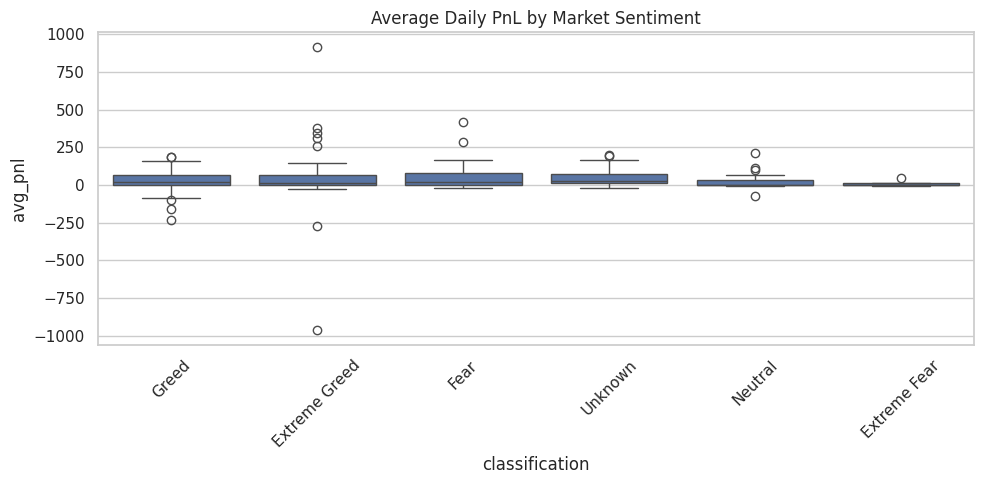

In [58]:
# Boxplot avg/total pnl by sentiment
plt.figure(figsize=(10,5))
order = daily['classification'].value_counts().index.tolist()
sns.boxplot(data=daily, x='classification', y='avg_pnl', order=order)
plt.title("Average Daily PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/boxplot_avg_pnl_by_sentiment.png")
plt.show()


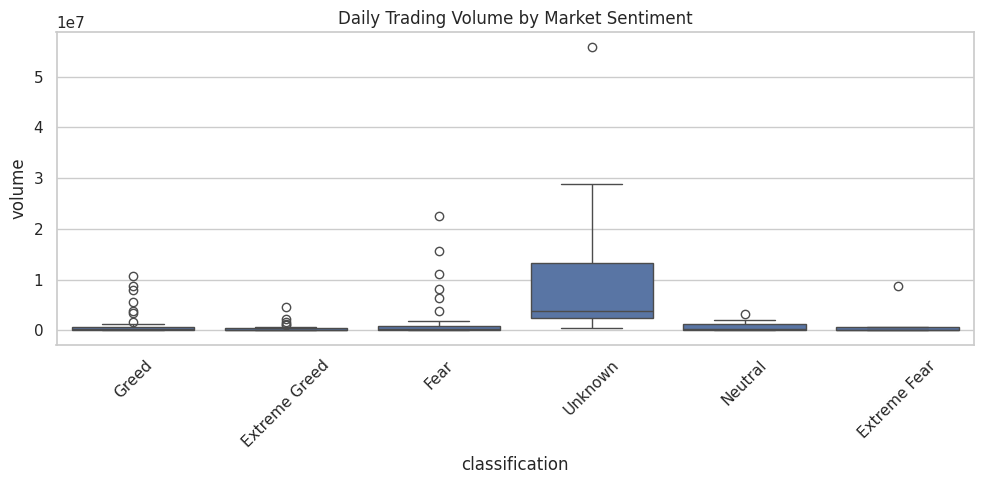

In [59]:
plt.figure(figsize=(10,5))
sns.boxplot(data=daily, x='classification', y='volume', order=order)
plt.title("Daily Trading Volume by Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/boxplot_volume_by_sentiment.png")
plt.show()


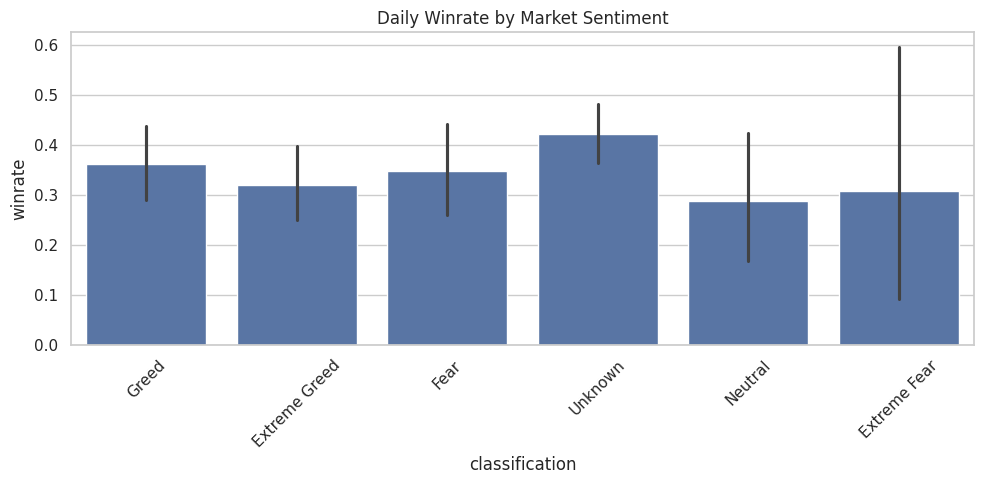

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(data=daily, x='classification', y='winrate', order=order)
plt.title("Daily Winrate by Market Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/bar_winrate_by_sentiment.png")
plt.show()


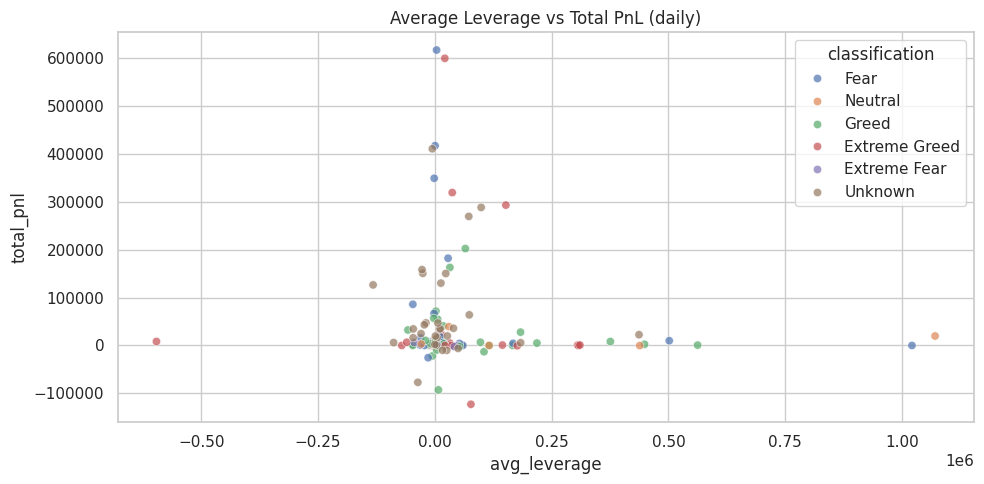

In [61]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=daily, x='avg_leverage', y='total_pnl', hue='classification', alpha=0.7)
plt.title("Average Leverage vs Total PnL (daily)")
plt.tight_layout()
plt.savefig("outputs/scatter_leverage_vs_pnl.png")
plt.show()


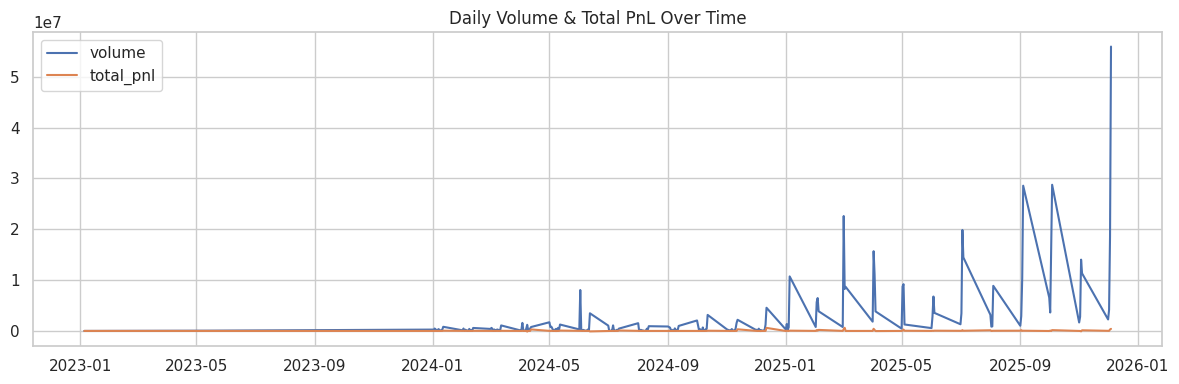

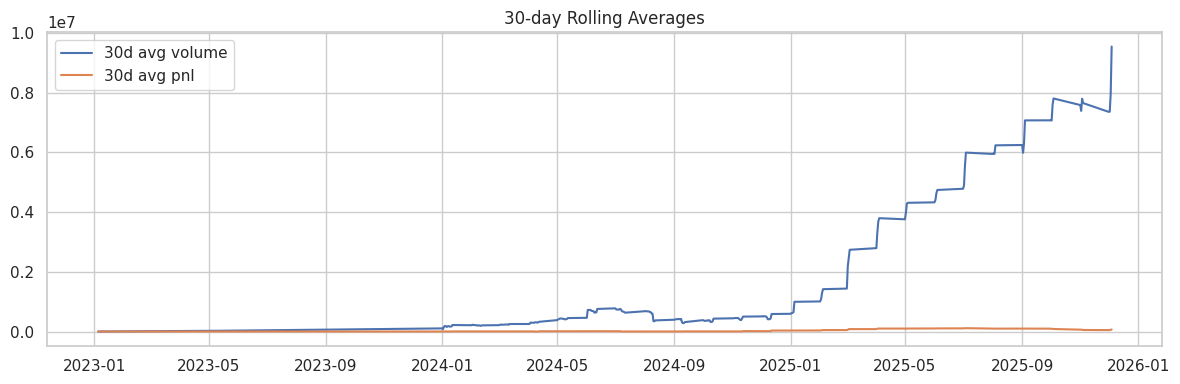

In [62]:
# Time series of volume and rolling averages
daily['date_dt'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date_dt')

plt.figure(figsize=(12,4))
plt.plot(daily['date_dt'], daily['volume'], label='volume')
plt.plot(daily['date_dt'], daily['total_pnl'], label='total_pnl')
plt.title("Daily Volume & Total PnL Over Time")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/timeseries_volume_pnl.png")
plt.show()

# 30-day rolling
daily[['volume_roll30','pnl_roll30']] = daily[['volume','total_pnl']].rolling(30, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(daily['date_dt'], daily['volume_roll30'], label='30d avg volume')
plt.plot(daily['date_dt'], daily['pnl_roll30'], label='30d avg pnl')
plt.title("30-day Rolling Averages")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/rolling_30d.png")
plt.show()


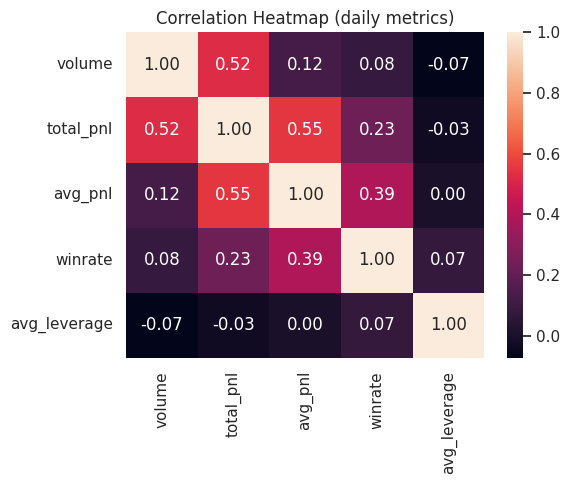

In [63]:
plt.figure(figsize=(6,5))
corr_cols = ['volume','total_pnl','avg_pnl','winrate','avg_leverage']
corr_cols = [c for c in corr_cols if c in daily.columns]
sns.heatmap(daily[corr_cols].corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap (daily metrics)")
plt.tight_layout()
plt.savefig("outputs/correlation_heatmap.png")
plt.show()


## Statistical tests (Fear vs Greed)



In [64]:
fg = daily[daily['classification'].str.lower().isin(['fear','greed'])]
fear = fg[fg['classification'].str.lower()=='fear']
greed = fg[fg['classification'].str.lower()=='greed']

def welch_ttest(a, b):
    a = a.dropna()
    b = b.dropna()
    if len(a) < 3 or len(b) < 3:
        return None
    res = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
    return res

tests = {}
for metric in ['volume','total_pnl','winrate','avg_leverage','avg_pnl']:
    if metric in daily.columns:
        tests[metric] = welch_ttest(fear[metric], greed[metric])


for k,v in tests.items():
    print(k, ":", v)


volume : TtestResult(statistic=np.float64(1.3373126492271343), pvalue=np.float64(0.18768676862624914), df=np.float64(46.06516429193822))
total_pnl : TtestResult(statistic=np.float64(1.6542907215642328), pvalue=np.float64(0.10585133025087051), df=np.float64(40.229618413773615))
winrate : TtestResult(statistic=np.float64(-0.23548007770081522), pvalue=np.float64(0.8144653801768079), df=np.float64(76.50042001104445))
avg_leverage : TtestResult(statistic=np.float64(0.09455100468171235), pvalue=np.float64(0.9250221974740485), df=np.float64(53.884027188083394))
avg_pnl : TtestResult(statistic=np.float64(1.5491942565876626), pvalue=np.float64(0.12613509434406783), df=np.float64(65.75335003261664))


## Interpretation & Next steps (write your observations here)
- Summarize the statistical test outputs and visual findings.
- Suggest trading implications (e.g., reduce leverage on Fear days).
- Note limitations and ideas for modeling (lag features, classifier).


In [65]:
report_md = """Title: Trader Behavior vs Market Sentiment
Candidate: Damala Siddhartha Alexander

(Write your executive summary and insert test results & images)
"""
with open("ds_report.md", "w") as f:
    f.write(report_md)


readme = f"""ds_damala_siddhartha_alexander

How to run:
1) Open notebook_1.ipynb in Colab
2) Place datasets: historical_trader_data.csv and fear_greed_index.csv in workspace or Drive
3) Run all cells
4) Outputs: csv_files/, outputs/, ds_report.md

Prepared by:
Damala Siddhartha Alexander
"""
with open("README.md", "w") as f:
    f.write(readme)



## Final actions before submission
1. Rename this Colab file to `notebook_1.ipynb` then File → Save a copy in Drive.  
2. Open README.md and ds_report.md — fill the executive summary and paste numeric test results & key observations.  
3. Export ds_report.md to PDF (or copy content to Google Docs and export to PDF) and place `ds_report.pdf` in root.  
4. Upload the root folder to GitHub with the exact structure:
   ds_damala_siddhartha_alexander/
   ├── notebook_1.ipynb
   ├── csv_files/
   ├── outputs/
   ├── ds_report.pdf
   └── README.md
5. Share the Colab link (Anyone with the link can view) in your application.
